# Initial Experiment -> Multiple Explainers

In this experiment, I am running all three explanation methods over a set of 10 instances which include:

- '9606.ENSP00000269228' # NPC1 which is known to have involvement in the cholesterol homeostasis process
- '9606.ENSP00000289989' # Closest to SREBP2 and has label 1 (expected)
- '9606.ENSP00000415836' # Far from SREBP2 and has label 0 (expected)
- '9606.ENSP00000216180' # Closest to SREBP2 but has label 0 (unexpected)
- '9606.ENSP00000359398' # Far from SREBP2 but has label 1 (Unexpected)
- '9606.ENSP00000346046' # False Negative (lowest confidence)
- '9606.ENSP00000473036' # True Negative (lowest confidence)
- '9606.ENSP00000449270' # False Positive (highest confidence)
- '9606.ENSP00000270176' # True Positive (highest confidence)

From each method, I will measuring the metrics:
 
- Runtime
- Fidelity 
- Stability


## Setup Experiments

Here I am performing set up for the experiments to take place. The set up includes: 

- install all necessary packages
- define the GNN model
- load in data
- load in model
- extract feature and node labels

In [315]:
# install necessary packages

%pip install torch_geometric # install pytorch geometric
%pip install torchvision #install torchvision
%pip install matplotlib #install matplotlib
%pip install graphviz # install graphviz

%matplotlib inline

from torch_geometric.data import Data, DataLoader
from torch_geometric.explain import GNNExplainer,Explainer,GraphMaskExplainer,PGExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv
from torch.nn import Linear,Softmax
import os
from tqdm import tqdm, trange
import pickle
from torch_geometric.explain.metric import fidelity, characterization_score

import matplotlib.pyplot as plt

Python(93740) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


Python(93771) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


Python(93776) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


Python(93786) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


In [316]:
# define GNN 

class SimpleGAT_1(torch.nn.Module):
    """
    A graph attention network with 4 graph layers and 2 linear layers.
    Uses v2 of graph attention that provides dynamic instead of static attention.
    The graph layer dimension and number of attention heads can be specified.
    """
    #torch.device('mps')
    def __init__(self, dataset, dim=8, num_heads=4):
        super(SimpleGAT_1, self).__init__()
        torch.manual_seed(seed=123)
        self.conv1 = GATv2Conv(in_channels=dataset.num_features, out_channels=dim, heads=num_heads,edge_dim=dataset.edge_attr.shape[1])
        self.conv2 = GATv2Conv(in_channels=dim * num_heads, out_channels=dim, heads=num_heads,edge_dim=dataset.edge_attr.shape[1])
        self.lin1 = Linear(dim * num_heads,dim)
        self.lin2 = Linear(dim,1)

    def forward(self, x, edge_index,edge_attr):
        h = self.conv1(x, edge_index,edge_attr).relu()
        h = self.conv2(h, edge_index,edge_attr).relu()
        h = self.lin1(h).relu()
        #print(h)
        h = F.dropout(h, p=0.1, training=self.training)
        out = self.lin2(h)[:,0]
        out = torch.sigmoid(out)
        return out

In [317]:
# load in data and fit GNN model 

data = torch.load('../SREBP2_0.pt')
model_path = '../SimpleGAT_1_model_lr_0.0001_dp_0.7.pth'
model = SimpleGAT_1(data,dim = 16)
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
model.eval()

SimpleGAT_1(
  (conv1): GATv2Conv(165, 16, heads=4)
  (conv2): GATv2Conv(64, 16, heads=4)
  (lin1): Linear(in_features=64, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=1, bias=True)
)

In [318]:
# Use data to get feature labels and remove all elements of data that are not a feature label

feat_labels = list(data.to_dict().keys())
to_remove = ['edge_index', 
 'experimental',
 'database',
 'textmining',
 'combined_score',
 'binary_experimental',
 'binary_database',
 'binary_textmining',
 'num_nodes',
 'x',
 'y',
 'edge_attr',
 'num_classes',
 'label']

for element in to_remove:
    feat_labels.remove(element)

In [319]:
# extract node labels and testing nodes from node order 

""" 
- '9606.ENSP00000269228' # NPC1 which is known to have involvement in the cholesterol homeostasis process
- '9606.ENSP00000289989' # Closest to SREBP2 and has label 1 (expected)
- '9606.ENSP00000415836' # Far from SREBP2 and has label 0 (expected)
- '9606.ENSP00000216180' # Closest to SREBP2 but has label 0 (unexpected)
- '9606.ENSP00000359398' # Far from SREBP2 but has label 1 (Unexpected)
- '9606.ENSP00000346046' # False Negative (lowest confidence)
- '9606.ENSP00000473036' # True Negative (lowest confidence)
- '9606.ENSP00000449270' # False Positive (highest confidence)
- '9606.ENSP00000270176' # True Positive (highest confidence)
"""

with open('../node_order.pickle', 'rb') as f:
    node_order = pickle.load(f)

node_labels = list(node_order.keys())

test_nodes = [node_order['9606.ENSP00000269228'], # NPC1 which is known to have involvement in the cholesterol homeostasis process
                node_order['9606.ENSP00000289989'], # Closest to SREBP2 and has label 1 (expected)
                node_order['9606.ENSP00000415836'], # Far from SREBP2 and has label 0 (expected)
                node_order['9606.ENSP00000216180'], # Closest to SREBP2 but has label 0 (unexpected)
                node_order['9606.ENSP00000359398'], # Far from SREBP2 but has label 1 (Unexpected)
                node_order['9606.ENSP00000346046'], # False Negative (lowest confidence)
                node_order['9606.ENSP00000473036'], # True Negative (lowest confidence)
                node_order['9606.ENSP00000449270'], # False Positive (highest confidence)
                node_order['9606.ENSP00000270176'] ]# True Positive (highest confidence) 

test_nodes_truth = [1, 1, 0, 0, 1, 0, 0, 1, 1]

## Experiments

In this section, I will be actually conducting all of the experiments. In this experiment, we are restricting k = 10. 

1. Define Explainers:
    - GNN Explainer with Node Mask = Attributes : **gnn_attr**
    - GNN Explainer with Node Mask = Common Attributes : **gnn_common**
    - PGExplainer : **pg**
    - GraphMask with Node Mask = Attributes : **gm_attr**
    - GraphMask with Node Mask = Common Attributes : **gm_common**
2. Define trials:
    - trial 
        - One trial of the experiment -> Using one explainer, finds an explanation on each of the test nodes. 
        - For each explanation, the positive fidelity score, negative fidelity score, wall runtime, process runtime, and explanation object are recorded.
        - Returns a dictionary with keys {'positive_fid', 'negative_fid',  'wall_times', 'process_times', 'explanations'}
    - pg_trial
        - One trial of the experiment for PGExplainer only - Using one PG explainer, finds an explanation on each of the test nodes. 
        - To use PGExplainer, the explainer must be trained, which is done in this function. 
        - For each explanation, the positive fidelity score, negative fidelity score, wall runtime, process runtime, and explanation object are recorded.
        - Returns a dictionary with keys {'positive_fid', 'negative_fid',  'wall_times', 'process_times', 'explanations'}
3. Run trials on all Explainers


### Define Explainers

In [320]:
# define explainers
gnn_attr = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    threshold_config=dict(
        threshold_type="topk",
        value=10 
    ),
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',
    ),
)

gnn_common = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='common_attributes',
    edge_mask_type='object',
    threshold_config=dict(
        threshold_type="topk",
        value=10 
    ),
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',
    ),
)

pg = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=30, lr=0.003),
    explanation_type='phenomenon',
    edge_mask_type='object',
    threshold_config=dict(
        threshold_type="topk",
        value=10 
    ),
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',
    ),
)

gm_attr = Explainer(
    model=model,
    algorithm=GraphMaskExplainer(2, epochs=5),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    threshold_config=dict(
        threshold_type="topk",
        value=10 
    ),
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',
    ), 
)

gm_comm = Explainer(
    model=model,
    algorithm=GraphMaskExplainer(2, epochs=5),
    explanation_type='model',
    node_mask_type='common_attributes',
    edge_mask_type='object',
    threshold_config=dict(
        threshold_type="topk",
        value=10 
    ),
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',
    ),
)

### Define Helper Functions

In [321]:
def fidelity_score(fids):
    """
    Takes in list of fidelity scores across multiple instances, and returns overall fidelity score at the model level
    """
    return 1 - sum(fids)/len(fids)

In [322]:
import time
def trial(explainer):
    """
    One trial of the experiment - Using one explainer, finds an explanation on each of the test nodes. 
    For each explanation, the positive fidelity score, negative fidelity score, wall runtime, process runtime, and explanation object are recorded.
    Returns a dictionary with keys {'positive_fid', 'negative_fid',  'wall_times', 'process_times', 'explanations'}
    """
    fid_pos = []
    fid_neg = []
    wall_times = []
    process_times = []
    explanations = []

    for node in test_nodes:
        start = time.time()
        process_start = time.process_time()
        explanation = explainer(data.x, data.edge_index, edge_attr=data.edge_attr, index = node)
        process_end = time.process_time()
        end = time.time()
        fid = fidelity(explainer, explanation)
        fid_pos.append(fid[0])
        fid_neg.append(fid[1])
        wall_times.append(end - start)
        process_times.append(process_end - process_start)
        explanations.append(explanation)
        # explanation.visualize_subgraph(path=f"trial_figs/{explainer}_{node}.pdf", backend='graphviz')

    return {'positive_fid' : fid_pos, 'negative_fid': fid_neg, 'wall_times': wall_times, 'process_times': process_times, 'explanations': explanations}

In [327]:
def pg_trial(explainer):
    """
    One trial of the experiment for PGExplainer only - Using one PG explainer, finds an explanation on each of the test nodes. 
    To use PGExplainer, the explainer must be trained, which is done in this function. 
    For each explanation, the positive fidelity score, negative fidelity score, wall runtime, process runtime, and explanation object are recorded.
    Returns a dictionary with keys {'positive_fid', 'negative_fid',  'wall_times', 'process_times', 'explanations'}
    """
    fid_pos = []
    fid_neg = []
    wall_times = []
    process_times = []
    explanations = []

    for node in test_nodes:
        start = time.time()
        process_start = time.process_time()
        for epoch in range(30):
            loss = explainer.algorithm.train(epoch, model, data.x, data.edge_index,
                                         target=data.y, index=node, edge_attr = data.edge_attr)

        explanation = explainer(data.x, data.edge_index, target=data.y, index=node, edge_attr = data.edge_attr)
        process_end = time.process_time()
        end = time.time()
        fid = fidelity(explainer, explanation)
        fid_pos.append(fid[0])
        fid_neg.append(fid[1])
        wall_times.append(end - start)
        process_times.append(process_end - process_start)
        explanations.append(explanation)

    return {'positive_fid' : fid_pos, 'negative_fid': fid_neg, 'wall_times': wall_times, 'process_times': process_times, 'explanations': explanations}

### Run Trials

In [324]:
gnn_exp_attr = trial(gnn_attr)

In [325]:
gnn_exp_common = trial(gnn_common)

In [328]:
pg_exp = pg_trial(pg)

In [329]:
gm_exp_attr = trial(gm_attr)

Train explainer for node(s) tensor([6179]) with layer 1: 100%|██████████| 5/5 [01:34<00:00, 18.82s/it]
Train explainer for node(s) tensor([6179]) with layer 0: 100%|██████████| 5/5 [04:31<00:00, 54.24s/it]
Explain: 100%|██████████| 2/2 [00:14<00:00,  7.02s/it]
Train explainer for node(s) tensor([17397]) with layer 1: 100%|██████████| 5/5 [02:08<00:00, 25.72s/it]
Train explainer for node(s) tensor([17397]) with layer 0: 100%|██████████| 5/5 [04:36<00:00, 55.23s/it]
Explain: 100%|██████████| 2/2 [00:18<00:00,  9.31s/it]
Train explainer for node(s) tensor([15315]) with layer 1: 100%|██████████| 5/5 [01:36<00:00, 19.27s/it]
Train explainer for node(s) tensor([15315]) with layer 0: 100%|██████████| 5/5 [04:18<00:00, 51.75s/it]
Explain: 100%|██████████| 2/2 [00:10<00:00,  5.18s/it]
Train explainer for node(s) tensor([9021]) with layer 1: 100%|██████████| 5/5 [01:56<00:00, 23.36s/it]
Train explainer for node(s) tensor([9021]) with layer 0: 100%|██████████| 5/5 [04:01<00:00, 48.31s/it]
Explain

In [330]:
gm_exp_common = trial(gm_comm)

Train explainer for node(s) tensor([6179]) with layer 1: 100%|██████████| 5/5 [02:01<00:00, 24.39s/it]
Train explainer for node(s) tensor([6179]) with layer 0: 100%|██████████| 5/5 [05:36<00:00, 67.21s/it]
Explain: 100%|██████████| 2/2 [00:13<00:00,  6.97s/it]
Train explainer for node(s) tensor([17397]) with layer 1: 100%|██████████| 5/5 [02:30<00:00, 30.12s/it]
Train explainer for node(s) tensor([17397]) with layer 0: 100%|██████████| 5/5 [04:15<00:00, 51.12s/it]
Explain: 100%|██████████| 2/2 [00:10<00:00,  5.39s/it]
Train explainer for node(s) tensor([15315]) with layer 1: 100%|██████████| 5/5 [01:35<00:00, 19.04s/it]
Train explainer for node(s) tensor([15315]) with layer 0: 100%|██████████| 5/5 [03:49<00:00, 45.91s/it]
Explain: 100%|██████████| 2/2 [00:08<00:00,  4.25s/it]
Train explainer for node(s) tensor([9021]) with layer 1: 100%|██████████| 5/5 [01:35<00:00, 19.11s/it]
Train explainer for node(s) tensor([9021]) with layer 0: 100%|██████████| 5/5 [05:09<00:00, 61.81s/it]
Explain

## Metrics & Visualizations

In [331]:
# make dict of all trials and their names

trial_names = {"GNNExplainer with Attributes" : gnn_exp_attr,  
               "GNN Explainer with Common Attributes": gnn_exp_common, 
               "PGExplainer" : pg_exp, 
               "GraphMask with Attributes" : gm_exp_attr, 
               "GraphMask with Common Attributes": gm_exp_common}

### Fidelity Metrics

In [333]:
import pandas as pd
import numpy as np
trials = []
for trial_name in trial_names:
    trial = trial_names[trial_name]
    pos_fid = fidelity_score(trial['positive_fid'])
    neg_fid = fidelity_score(trial['negative_fid'])
    avg_time = np.mean(trial['process_times']) / 60
    std_time = np.std(trial['process_times']) / 60
    d = {'explainer_type': trial_name, 'positive_fidelity': pos_fid, 'negative_fidelity': neg_fid, 'average_time_mins': avg_time, 'std_time': std_time}
    trials.append(d)


trials_df = pd.DataFrame(trials)
trials_df

,explainer_type,positive_fidelity,negative_fidelity,average_time_mins,std_time
0,GNNExplainer with Attributes,0.666667,0.333333,75.192229,1.490615
1,GNN Explainer with Common Attributes,0.333333,0.444444,77.243904,1.394734
2,PGExplainer,1.000000,0.333333,19.332911,0.116341
3,GraphMask with Attributes,0.333333,0.333333,10.470775,0.189830
4,GraphMask with Common Attributes,0.333333,0.333333,10.430285,0.329956


In [334]:
def get_k_features(explanation, k, feat_labels):
    node_mask = explanation.get('node_mask')
    if node_mask is None:
        raise ValueError("The attribute 'node_mask' is not available ")
    if node_mask.dim() != 2 or node_mask.size(1) <= 1:
        raise ValueError(f"Cannot compute feature importance for "
                            f"object-level 'node_mask' "
                            f"(got shape {node_mask.size()})")
    score = node_mask.sum(dim=0)
    score = score.cpu().numpy()
    df = pd.DataFrame({'score': score}, index=feat_labels)
    df = df.sort_values('score', ascending=False)
    df = df.round(decimals=3)
    return df.head(k)
    

### Global Feature Importance

In [292]:
top_features = pd.DataFrame()


for trial_name in trial_names:
    trial = trial_names[trial_name]
    for exps in trial['explanations']:
        try:
            feats = get_k_features(exps, 10, feat_labels)
            feats['explainer'] = trial_name
            top_features = pd.concat([top_features,feats])
        except:
            continue

top_features['feature_name'] = top_features.index
top_features = top_features.reset_index()
top_features = top_features.drop('index', axis=1)
top_features_count = top_features.groupby('feature_name').agg('count').reset_index()
top_features_count = top_features_count.sort_values('score', ascending=False)
top_features_count = top_features_count.head(10)
top_features_count = top_features_count.set_index('feature_name')
top_features_count

,score,explainer
feature_name,,
RNA line ab,13,13
cytoplasm,10,10
train_mask,10,10
go_feature_12,10,10
endomembrane system,8,8
plasma membrane,8,8
golgi apparatus,8,8
has_path,7,7
vesicles,7,7


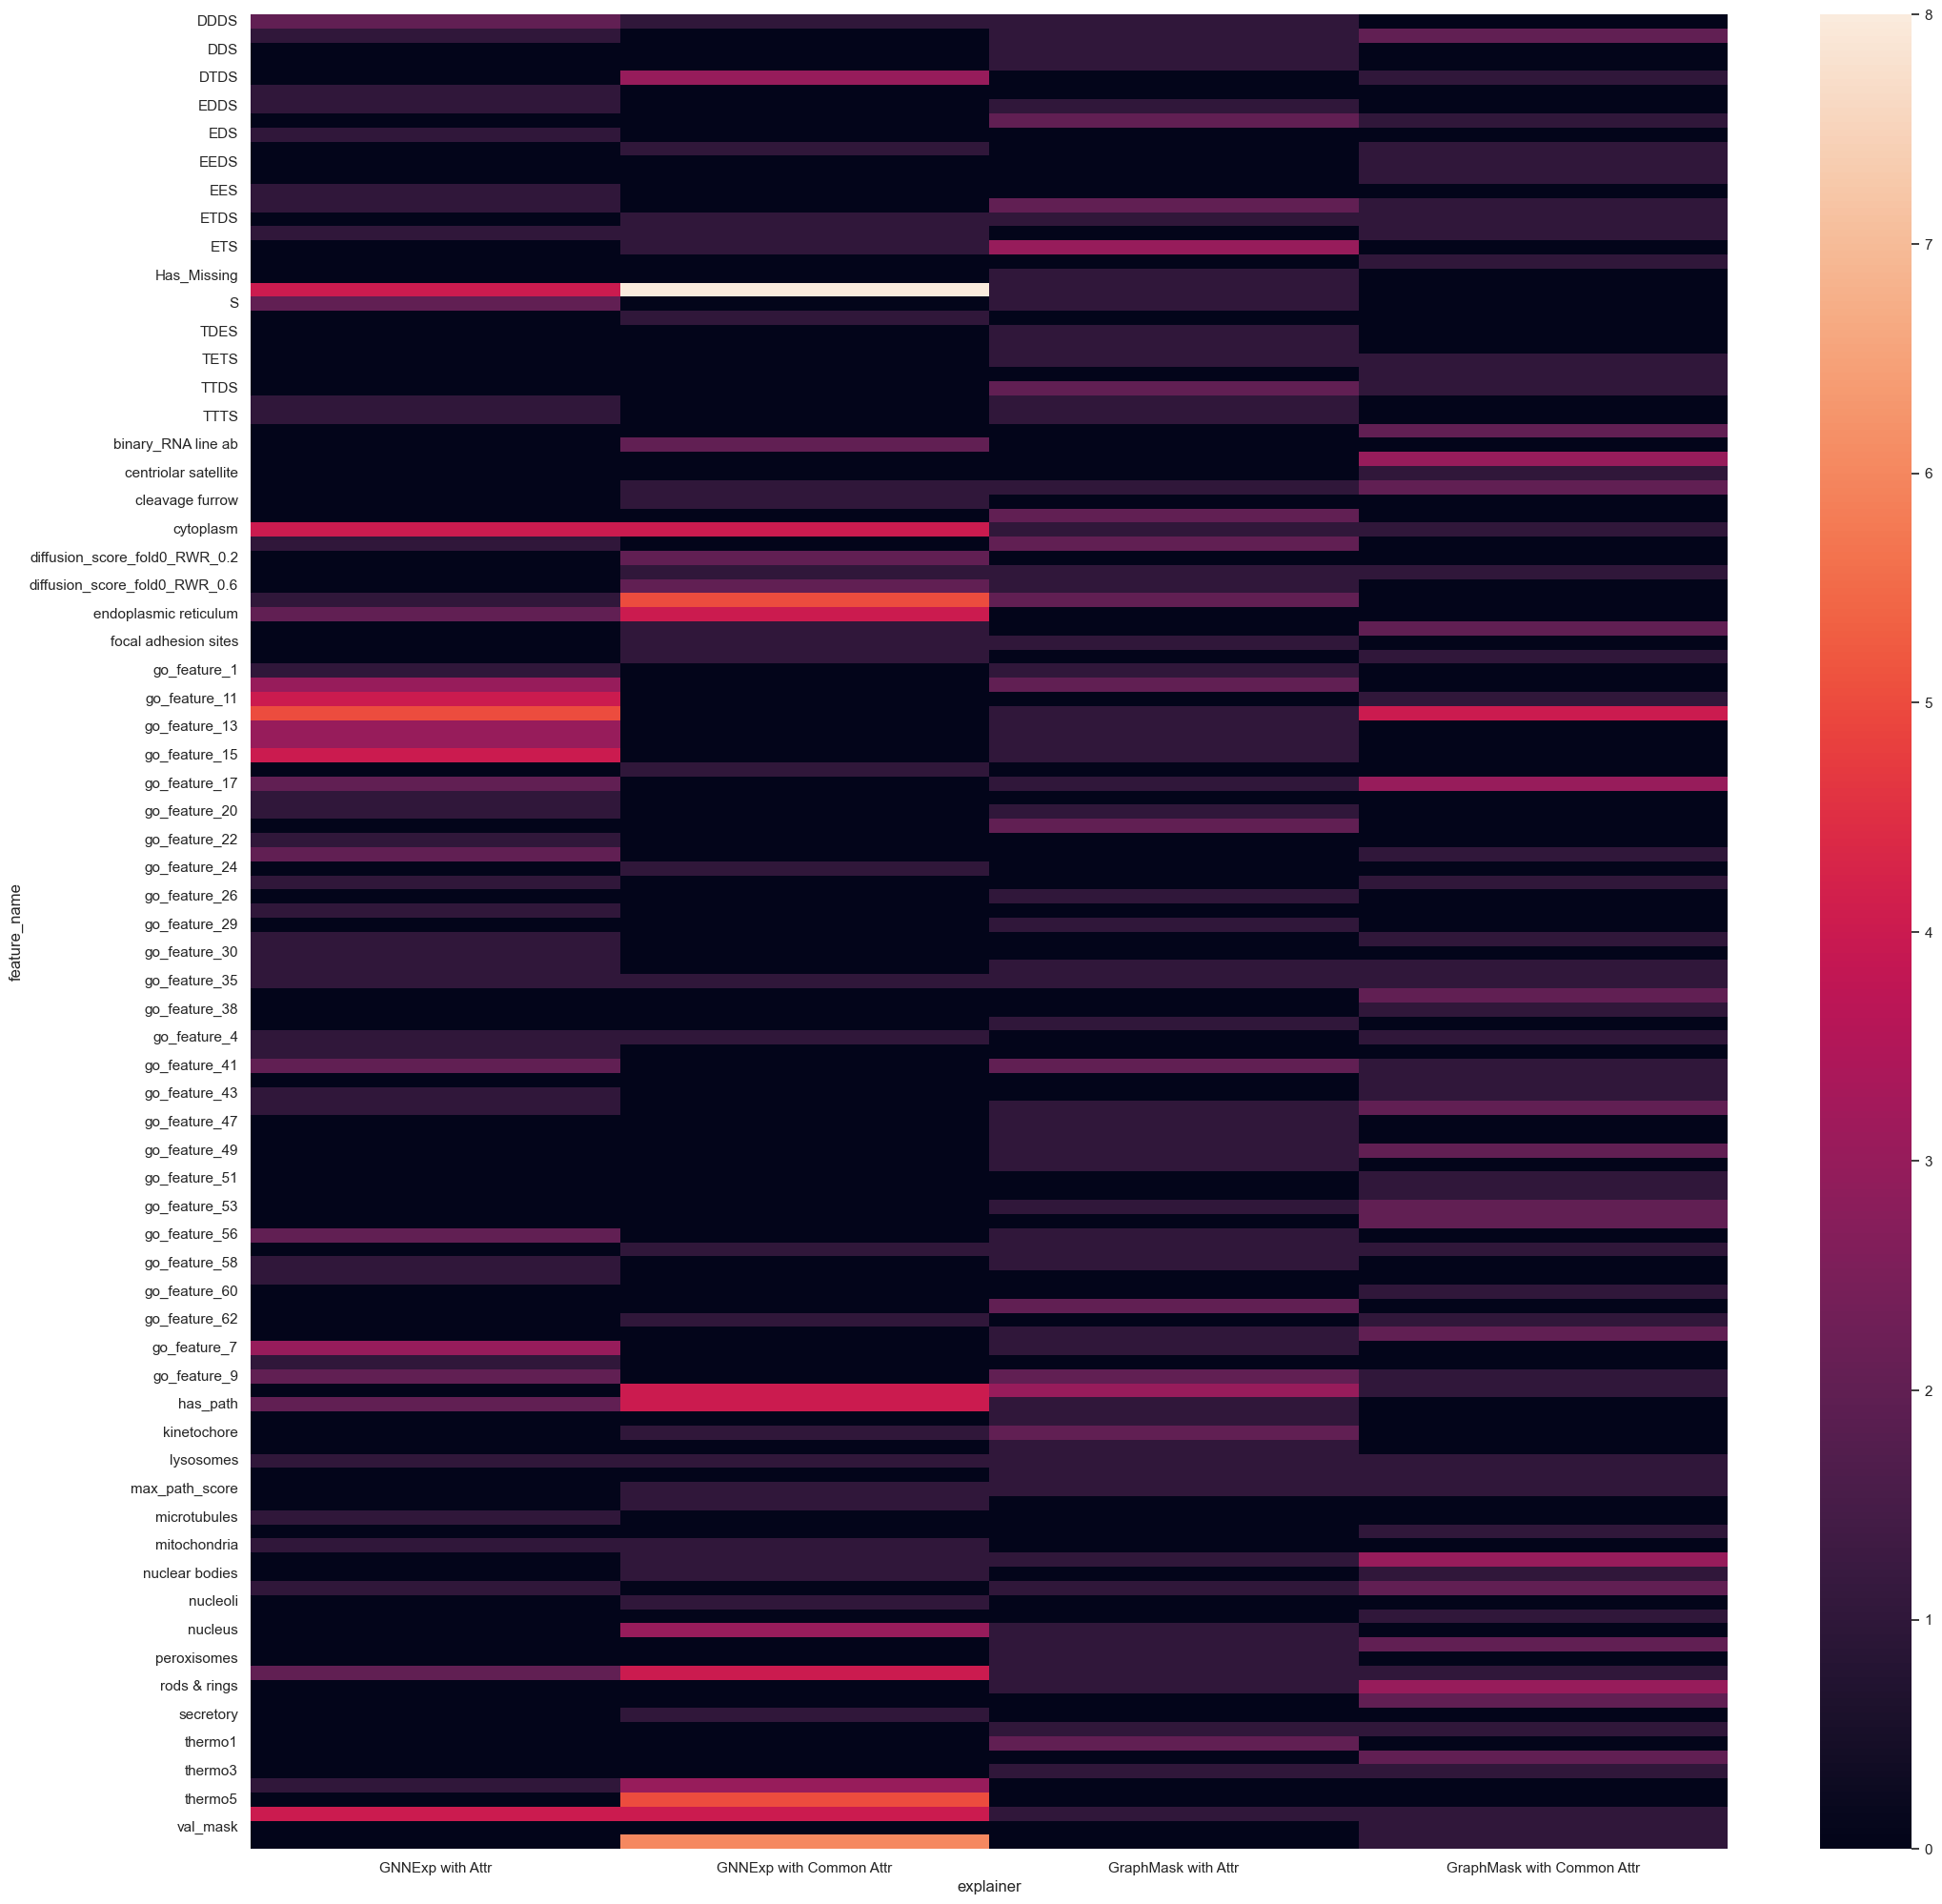

In [293]:
import seaborn as sns

tf = top_features.groupby(['explainer', 'feature_name']).agg('count').reset_index()

tf = tf.set_index('feature_name')
tf = tf.sort_values('score', ascending=False)
tf = pd.pivot_table(tf, values='score', index='feature_name',
                       columns=['explainer'], aggfunc="sum")
tf = tf.fillna(0)
plt.subplots(figsize=(25,25))
hm = sns.heatmap(tf)
hm.figure.savefig("heatmap.png")

<Axes: xlabel='explainer', ylabel='feature_name'>

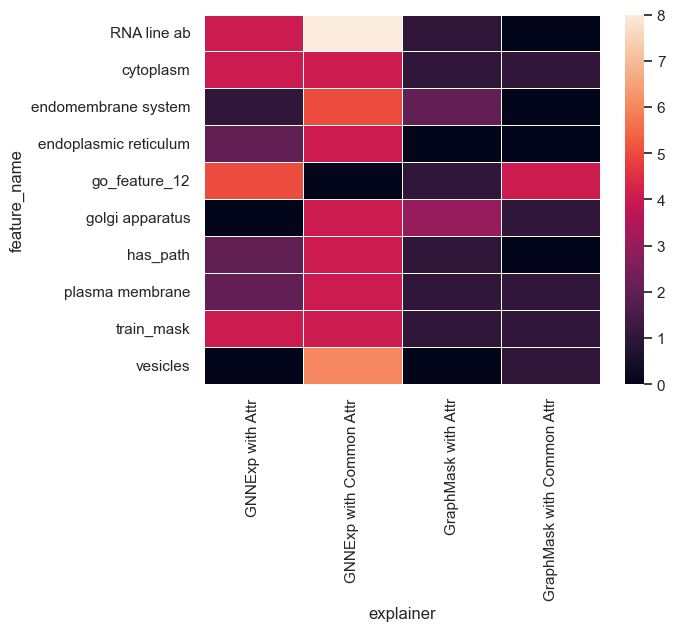

In [201]:
tf2 = tf[tf.index.isin(top_features_count.index)]
sns.heatmap(tf2, linewidths=0.5)

### Semi-Global Feature Importance

#### GNN Explainer with Attributes

In [287]:
gnn_attr_global_top_features = pd.DataFrame()


for exps in gnn_exp_attr['explanations']:
    try:
        feats = get_k_features(exps, 10, feat_labels)
        gnn_attr_global_top_features = pd.concat([gnn_attr_global_top_features, feats])
    except:
        continue

gnn_attr_global_top_features['feature_name'] = gnn_attr_global_top_features.index
gnn_attr_global_top_features = gnn_attr_global_top_features.reset_index()
gnn_attr_global_top_features = gnn_attr_global_top_features.drop('index', axis=1)
gnn_attr_global_top_features = gnn_attr_global_top_features.groupby('feature_name').agg('count').reset_index()
gnn_attr_global_top_features = gnn_attr_global_top_features.sort_values('score', ascending=False)
gnn_attr_global_top_features.head(10)

,feature_name,score
19,go_feature_12,5
52,train_mask,4
22,go_feature_15,4
12,cytoplasm,4
8,RNA line ab,4
18,go_feature_11,4
42,go_feature_7,3
17,go_feature_10,3
21,go_feature_14,3
20,go_feature_13,3


#### GNN Explainer with Common Attributes

In [288]:
gnn_common_global_top_features = pd.DataFrame()


for exps in gnn_exp_common['explanations']:
    try:
        feats = get_k_features(exps, 10, feat_labels)
        gnn_common_global_top_features = pd.concat([gnn_common_global_top_features, feats])
    except:
        continue

gnn_common_global_top_features['feature_name'] = gnn_common_global_top_features.index
gnn_common_global_top_features = gnn_common_global_top_features.reset_index()
gnn_common_global_top_features = gnn_common_global_top_features.drop('index', axis=1)
gnn_common_global_top_features = gnn_common_global_top_features.groupby('feature_name').agg('count').reset_index()
gnn_common_global_top_features = gnn_common_global_top_features.sort_values('score', ascending=False)
gnn_common_global_top_features.head(10)

,feature_name,score
6,RNA line ab,8
42,vesicles,6
40,thermo5,5
15,endomembrane system,5
11,cytoplasm,4
16,endoplasmic reticulum,4
26,golgi apparatus,4
27,has_path,4
41,train_mask,4
37,plasma membrane,4


#### GraphMask with Attributes

In [289]:
gm_attr_global_top_features = pd.DataFrame()


for exps in gm_exp_attr['explanations']:
    try:
        feats = get_k_features(exps, 10, feat_labels)
        gm_attr_global_top_features = pd.concat([gm_attr_global_top_features, feats])
    except:
        continue

gm_attr_global_top_features['feature_name'] = gm_attr_global_top_features.index
gm_attr_global_top_features = gm_attr_global_top_features.reset_index()
gm_attr_global_top_features = gm_attr_global_top_features.drop('index', axis=1)
gm_attr_global_top_features = gm_attr_global_top_features.groupby('feature_name').agg('count').reset_index()
gm_attr_global_top_features = gm_attr_global_top_features.sort_values('score', ascending=False)
gm_attr_global_top_features.head(10)

,feature_name,score
54,golgi apparatus,3
8,ETS,3
40,go_feature_41,2
34,go_feature_21,2
57,kinetochore,2
21,cytosol,2
27,go_feature_10,2
19,cytokinetic bridge,2
53,go_feature_9,2
15,TTDS,2


#### GraphMask with Common Attributes

In [290]:
gm_common_global_top_features = pd.DataFrame()


for exps in gm_exp_common['explanations']:
    try:
        feats = get_k_features(exps, 10, feat_labels)
        gm_common_global_top_features = pd.concat([gm_common_global_top_features, feats])
    except:
        continue

gm_common_global_top_features['feature_name'] = gm_common_global_top_features.index
gm_common_global_top_features = gm_common_global_top_features.reset_index()
gm_common_global_top_features = gm_common_global_top_features.drop('index', axis=1)
gm_common_global_top_features = gm_common_global_top_features.groupby('feature_name').agg('count').reset_index()
gm_common_global_top_features = gm_common_global_top_features.sort_values('score', ascending=False)
gm_common_global_top_features.head(10)

,feature_name,score
22,go_feature_12,4
14,cell junctions,3
23,go_feature_17,3
57,rods & rings,3
51,mitotic chromosome,3
0,DDES,2
35,go_feature_46,2
39,go_feature_53,2
40,go_feature_54,2
29,go_feature_36,2


# Stability Studies

In this section, I will be conducting stability studies using one explanation method on the same node. 

## Setup Experiments

In [219]:
def stability_trial(explainer, node):
    """
    One trial of a stability experiment - Using one explainer, finds an explanation on the input target node. 
    For each explanation, the positive fidelity score, negative fidelity score, wall runtime, process runtime, and explanation object are recorded.
    Returns a dictionary with keys {'positive_fid', 'negative_fid',  'wall_times', 'process_times', 'explanations'}
    This dict includes multiple explanations of the same explainer on the same node to explore stability 
    """
    fid_pos = []
    fid_neg = []
    wall_times = []
    process_times = []
    explanations = []

    for i in range(4):
        start = time.time()
        process_start = time.process_time()
        explanation = explainer(data.x, data.edge_index, edge_attr=data.edge_attr, index = node)
        process_end = time.process_time()
        end = time.time()
        fid = fidelity(explainer, explanation)
        fid_pos.append(fid[0])
        fid_neg.append(fid[1])
        wall_times.append(end - start)
        process_times.append(process_end - process_start)
        explanations.append(explanation)
        # explanation.visualize_subgraph(path=f"trial_figs/{explainer}_{node}.pdf", backend='graphviz')

    return {'positive_fid' : fid_pos, 'negative_fid': fid_neg, 'wall_times': wall_times, 'process_times': process_times, 'explanations': explanations}

In [274]:
def pg_stability_trial(explainer, node):
    """
    One trial of a stability experiment - Using one explainer, finds an explanation on the input target node. 
    For each explanation, the positive fidelity score, negative fidelity score, wall runtime, process runtime, and explanation object are recorded.
    Returns a dictionary with keys {'positive_fid', 'negative_fid',  'wall_times', 'process_times', 'explanations'}
    This dict includes multiple explanations of the same explainer on the same node to explore stability 
    """
    fid_pos = []
    fid_neg = []
    wall_times = []
    process_times = []
    explanations = []

    for i in range(4):
        start = time.time()
        process_start = time.process_time()
        for epoch in range(30):
            loss = explainer.algorithm.train(epoch, model, data.x, data.edge_index,
                                         target=data.y, index=node, edge_attr = data.edge_attr)

        explanation = explainer(data.x, data.edge_index, target=data.y, index=node, edge_attr = data.edge_attr)
        process_end = time.process_time()
        end = time.time()
        fid = fidelity(explainer, explanation)
        fid_pos.append(fid[0])
        fid_neg.append(fid[1])
        wall_times.append(end - start)
        process_times.append(process_end - process_start)
        explanations.append(explanation)
        # explanation.visualize_subgraph(path=f"trial_figs/{explainer}_{node}.pdf", backend='graphviz')

    return {'positive_fid' : fid_pos, 'negative_fid': fid_neg, 'wall_times': wall_times, 'process_times': process_times, 'explanations': explanations}

## Experiments

In [220]:
gnn_attr_stability = stability_trial(gnn_attr, test_nodes[0])

In [221]:
gnn_common_stability = stability_trial(gnn_common, test_nodes[0])

In [275]:
pg_stability = pg_stability_trial(pg, test_nodes[0])

In [222]:
gm_attr_stability = stability_trial(gm_attr, test_nodes[0])

Train explainer for node(s) tensor([6179]) with layer 1: 100%|██████████| 5/5 [01:14<00:00, 14.88s/it]
Train explainer for node(s) tensor([6179]) with layer 0: 100%|██████████| 5/5 [03:28<00:00, 41.68s/it]
Explain: 100%|██████████| 2/2 [00:09<00:00,  4.57s/it]
Train explainer for node(s) tensor([6179]) with layer 1: 100%|██████████| 5/5 [01:10<00:00, 14.08s/it]
Train explainer for node(s) tensor([6179]) with layer 0: 100%|██████████| 5/5 [03:41<00:00, 44.23s/it]
Explain: 100%|██████████| 2/2 [00:07<00:00,  3.89s/it]
Train explainer for node(s) tensor([6179]) with layer 1: 100%|██████████| 5/5 [01:25<00:00, 17.02s/it]
Train explainer for node(s) tensor([6179]) with layer 0: 100%|██████████| 5/5 [03:37<00:00, 43.51s/it]
Explain: 100%|██████████| 2/2 [00:09<00:00,  4.87s/it]
Train explainer for node(s) tensor([6179]) with layer 1: 100%|██████████| 5/5 [01:06<00:00, 13.22s/it]
Train explainer for node(s) tensor([6179]) with layer 0: 100%|██████████| 5/5 [03:42<00:00, 44.52s/it]
Explain: 10

In [223]:
gm_comm_stability = stability_trial(gm_comm, test_nodes[0])

Train explainer for node(s) tensor([6179]) with layer 1: 100%|██████████| 5/5 [01:03<00:00, 12.75s/it]
Train explainer for node(s) tensor([6179]) with layer 0: 100%|██████████| 5/5 [03:41<00:00, 44.22s/it]
Explain: 100%|██████████| 2/2 [00:08<00:00,  4.32s/it]
Train explainer for node(s) tensor([6179]) with layer 1: 100%|██████████| 5/5 [00:59<00:00, 11.88s/it]
Train explainer for node(s) tensor([6179]) with layer 0: 100%|██████████| 5/5 [02:59<00:00, 35.82s/it]
Explain: 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]
Train explainer for node(s) tensor([6179]) with layer 1: 100%|██████████| 5/5 [01:12<00:00, 14.47s/it]
Train explainer for node(s) tensor([6179]) with layer 0: 100%|██████████| 5/5 [03:43<00:00, 44.78s/it]
Explain: 100%|██████████| 2/2 [00:07<00:00,  3.73s/it]
Train explainer for node(s) tensor([6179]) with layer 1: 100%|██████████| 5/5 [01:03<00:00, 12.63s/it]
Train explainer for node(s) tensor([6179]) with layer 0: 100%|██████████| 5/5 [03:23<00:00, 40.66s/it]
Explain: 10

## Metrics & Visualizations

In [308]:
def edge_jaccard(edge_mask1, edge_mask2):
    edge_mask1 = np.array(edge_mask1)
    edge_mask2 = np.array(edge_mask2)
    edge_mask1[edge_mask1 > 0] = 1
    edge_mask2[edge_mask2 > 0] = 1
    intersection = np.sum(((edge_mask1 == edge_mask2) & (edge_mask1 == 1) & (edge_mask2 == 1)))
    union = np.sum(edge_mask1 == 1) + np.sum((edge_mask2 == 1)) - intersection
    return intersection / union

### GNN Explainer with Attributes

In [341]:
# edge stability
gnn_attr_edge_similarity = []

for i in range(4):
    for j in range(i, 4):
        if i == j:
            continue
        exp1 = i
        exp2 = j
        edge_mask1 = gnn_attr_stability['explanations'][i].edge_mask
        edge_mask2 = gnn_attr_stability['explanations'][j].edge_mask
        edge_sim = edge_jaccard(edge_mask1, edge_mask2)
        gnn_attr_edge_similarity.append({'Explanation 1': exp1, 'Explanation 2': exp2, 'Jaccard Similarity': edge_sim})

gnn_attr_edge_similarity = pd.DataFrame(gnn_attr_edge_similarity)
gnn_attr_edge_similarity

,Explanation 1,Explanation 2,Jaccard Similarity
0,0,1,0.666667
1,0,2,0.818182
2,0,3,0.666667
3,1,2,0.666667
4,1,3,0.666667
5,2,3,0.538462


In [338]:
# feature stability
top_features = pd.DataFrame()

count = 0
for exps in gnn_attr_stability['explanations']:
    name = count
    try:
        feats = get_k_features(exps, 10, feat_labels)
        feats['explainer'] = name
        top_features = pd.concat([top_features,feats])
    except:
        continue
    count+=1

top_features['feature_name'] = top_features.index
top_features = top_features.reset_index()
top_features = top_features.drop('index', axis=1)
top_features_count = top_features.groupby('feature_name').agg('count').reset_index()
top_features_count = top_features_count.sort_values('score', ascending=False)
# top_features_count = top_features_count.head(10)
top_features_count = top_features_count.set_index('feature_name')
top_features_count


,score,explainer
feature_name,,
go_feature_15,3,3
go_feature_61,3,3
go_feature_56,3,3
go_feature_45,2,2
go_feature_48,2,2
thermo4,2,2
plasma membrane,2,2
go_feature_16,2,2
EDS,2,2


### GNN Explainer with Common Attributes

In [342]:
# edge stability
gnn_common_edge_similarity = []

for i in range(4):
    for j in range(i, 4):
        if i == j:
            continue
        exp1 = i
        exp2 = j
        edge_mask1 = gnn_common_stability['explanations'][i].edge_mask
        edge_mask2 = gnn_common_stability['explanations'][j].edge_mask
        edge_sim = edge_jaccard(edge_mask1, edge_mask2)
        gnn_common_edge_similarity.append({'Explanation 1': exp1, 'Explanation 2': exp2, 'Jaccard Similarity': edge_sim})

gnn_common_edge_similarity = pd.DataFrame(gnn_common_edge_similarity)
gnn_common_edge_similarity

,Explanation 1,Explanation 2,Jaccard Similarity
0,0,1,0.818182
1,0,2,1.000000
2,0,3,1.000000
3,1,2,0.818182
4,1,3,0.818182
5,2,3,1.000000


In [296]:

gnn_common_stability['explanations'][0].visualize_graph(path="g0.pdf", backend='graphviz')
gnn_common_stability['explanations'][1].visualize_graph(path="g1.pdf", backend='graphviz')
gnn_common_stability['explanations'][2].visualize_graph(path="g2.pdf", backend='graphviz')
gnn_common_stability['explanations'][3].visualize_graph(path="g3.pdf", backend='graphviz')


Python(70207) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(70208) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(70209) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(70210) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [343]:
# GNN Explainer with Common Attributes

top_features = pd.DataFrame()

count = 0
for exps in gnn_common_stability['explanations']:
    name = count
    try:
        feats = get_k_features(exps, 10, feat_labels)
        feats['explainer'] = name
        top_features = pd.concat([top_features,feats])
    except:
        continue
    count+=1

top_features['feature_name'] = top_features.index
top_features = top_features.reset_index()
top_features = top_features.drop('index', axis=1)
top_features_count = top_features.groupby('feature_name').agg('count').reset_index()
top_features_count = top_features_count.sort_values('score', ascending=False)
# top_features_count = top_features_count.head(10)
top_features_count = top_features_count.set_index('feature_name')
top_features_count

,score,explainer
feature_name,,
RNA line ab,4,4
endomembrane system,4,4
endosomes,4,4
golgi apparatus,4,4
plasma membrane,4,4
vesicles,4,4
thermo4,3,3
thermo5,3,3
train_mask,3,3


### PG Explainer

In [312]:
# edge stability
pg_edge_similarity = []

for i in range(4):
    for j in range(4):
        if i == j:
            continue
        exp1 = i
        exp2 = j
        edge_mask1 = gm_attr_stability['explanations'][i].edge_mask
        edge_mask2 = gm_attr_stability['explanations'][j].edge_mask
        edge_sim = edge_jaccard(edge_mask1, edge_mask2)
        pg_edge_similarity.append({'Explainer 1': exp1, 'Explainer 2': exp2, 'Jaccard Similarity': edge_sim})

pg_edge_similarity = pd.DataFrame(pg_edge_similarity)
pg_edge_similarity


,Explainer 1,Explainer 2,Jaccard Similarity
0,0,1,0.818182
1,0,2,0.818182
2,0,3,0.818182
3,1,0,0.818182
4,1,2,0.818182
5,1,3,1.000000
6,2,0,0.818182
7,2,1,0.818182
8,2,3,0.818182
9,3,0,0.818182


### GraphMask with Attributes

In [313]:
# edge stability
gm_attr_edge_similarity = []

for i in range(4):
    for j in range(4):
        if i == j:
            continue
        exp1 = i
        exp2 = j
        edge_mask1 = gm_attr_stability['explanations'][i].edge_mask
        edge_mask2 = gm_attr_stability['explanations'][j].edge_mask
        edge_sim = edge_jaccard(edge_mask1, edge_mask2)
        gm_attr_edge_similarity.append({'Explainer 1': exp1, 'Explainer 2': exp2, 'Jaccard Similarity': edge_sim})

gm_attr_edge_similarity = pd.DataFrame(gm_attr_edge_similarity)
gm_attr_edge_similarity

,Explainer 1,Explainer 2,Jaccard Similarity
0,0,1,0.818182
1,0,2,0.818182
2,0,3,0.818182
3,1,0,0.818182
4,1,2,0.818182
5,1,3,1.000000
6,2,0,0.818182
7,2,1,0.818182
8,2,3,0.818182
9,3,0,0.818182


In [234]:
# GM with Attributes

top_features = pd.DataFrame()

count = 0
for exps in gm_attr_stability['explanations']:
    name = count
    try:
        feats = get_k_features(exps, 10, feat_labels)
        feats['explainer'] = name
        top_features = pd.concat([top_features,feats])
    except:
        continue
    count+=1

top_features['feature_name'] = top_features.index
top_features = top_features.reset_index()
top_features = top_features.drop('index', axis=1)
top_features_count = top_features.groupby('feature_name').agg('count').reset_index()
top_features_count = top_features_count.sort_values('score', ascending=False)
# top_features_count = top_features_count.head(10)
top_features_count = top_features_count.set_index('feature_name')
top_features_count

,score,explainer
feature_name,,
DEDS,2,2
secreted proteins,2,2
go_feature_29,2,2
go_feature_24,2,2
nuclear bodies,2,2
TDTS,2,2
go_feature_46,2,2
thermo0,1,1
nucleoplasm,1,1


### GM with Common Attributes

In [314]:
# edge stability
gm_comm_edge_similarity = []

for i in range(4):
    for j in range(4):
        if i == j:
            continue
        exp1 = i
        exp2 = j
        edge_mask1 = gm_comm_stability['explanations'][i].edge_mask
        edge_mask2 = gm_comm_stability['explanations'][j].edge_mask
        edge_sim = edge_jaccard(edge_mask1, edge_mask2)
        gm_comm_edge_similarity.append({'Explainer 1': exp1, 'Explainer 2': exp2, 'Jaccard Similarity': edge_sim})

gm_comm_edge_similarity = pd.DataFrame(gm_comm_edge_similarity)
gm_comm_edge_similarity

,Explainer 1,Explainer 2,Jaccard Similarity
0,0,1,0.666667
1,0,2,1.000000
2,0,3,1.000000
3,1,0,0.666667
4,1,2,0.666667
5,1,3,0.666667
6,2,0,1.000000
7,2,1,0.666667
8,2,3,1.000000
9,3,0,1.000000


In [235]:
# GM with Common Attributes

top_features = pd.DataFrame()

count = 0
for exps in gm_comm_stability['explanations']:
    name = count
    try:
        feats = get_k_features(exps, 10, feat_labels)
        feats['explainer'] = name
        top_features = pd.concat([top_features,feats])
    except:
        continue
    count+=1

top_features['feature_name'] = top_features.index
top_features = top_features.reset_index()
top_features = top_features.drop('index', axis=1)
top_features_count = top_features.groupby('feature_name').agg('count').reset_index()
top_features_count = top_features_count.sort_values('score', ascending=False)
# top_features_count = top_features_count.head(10)
top_features_count = top_features_count.set_index('feature_name')
top_features_count

,score,explainer
feature_name,,
diffusion_score_fold0_RWR_0.2,3,3
go_feature_61,2,2
midbody,2,2
DTTS,1,1
nuclear membrane,1,1
go_feature_60,1,1
go_feature_62,1,1
microtubules,1,1
midbody ring,1,1
